# Import Libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import Imputer,LabelEncoder,StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import KFold
from sklearn.svm import NuSVC
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.metrics import roc_curve
%matplotlib inline 

# Load the training Dataframe

In [2]:
training_dataframe = pd.read_csv("./data/cleaned_training_data.csv")

# Data is having class imbalance problem

{'Bad': 463, 'Good': 3240}

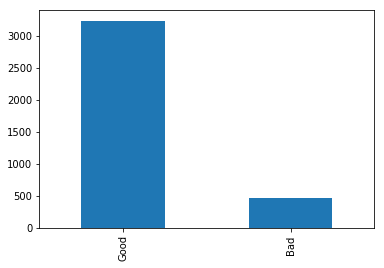

In [3]:
training_dataframe.Machine_State.value_counts().plot(kind='bar')
training_dataframe.Machine_State.value_counts().to_dict()

In [4]:
training_data_matrix = training_dataframe.as_matrix()
feature_names = training_dataframe.columns[:-1]


X_train = training_data_matrix[:,:-1]
y_train = training_data_matrix[:,-1]

# Transformers Defined

In [5]:
def impute_missing_data(X):
    imp = Imputer(missing_values=np.nan,strategy='mean',axis=0,verbose=1)
    imp.fit(X)
    X_imputed = imp.transform(X)
    return X_imputed

def encode_decision(y):
    encoder= LabelEncoder()
    encoder.fit(y)
    print(encoder)
    y_encoded=encoder.transform(y)
    return y_encoded

def standardize_data(X):
    scaler = StandardScaler()
    scaler.fit(X)
    X_standardized = scaler.transform(X)
    return X_standardized

def remove_outliers(X,y):
    print("Number of records before removing outliers ",X.shape[0])
    lof = LocalOutlierFactor(n_neighbors=20,n_jobs=-1)
    non_outlier_indices = lof.fit_predict(X)==1
    X_inlier = X[non_outlier_indices]
    y_inlier = y[non_outlier_indices]
    print("Number of records after removing outliers ",X_inlier.shape[0])
    return X_inlier,y_inlier

def create_orthogonal_matrix(X):
    pca = PCA(n_components=60,random_state=0)
    X_orthogonal = pca.fit_transform(X)
    print("Number of attributes before PCA ",X.shape[1])
    print("Number of attributes after PCA ",X_orthogonal.shape[1])
    return X_orthogonal

def select_features(X,y):
    clf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)
    sfm = SelectFromModel(clf,threshold='mean')
    sfm.fit(X, y)
    X_important = sfm.transform(X)
    print(X_important.shape[1]," attributes are selected out of ",X.shape[1]," attributes by RF")
    return X_important

def over_sample_smote(X,y):
    smote = SMOTE(random_state=0,n_jobs=-1)
    smote.fit(X,y)
    X_resampled, y_resampled = smote.sample(X, y)
    print("Number of records before SMOTE sampling ",X.shape[0])
    print("Number of records after SMOTE sampling ",X_resampled.shape[0])
    return X_resampled,y_resampled

# Classifers defined

In [6]:
clf_LR = LogisticRegression(random_state=0)
clf_RF = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)
clf_LDA = LinearDiscriminantAnalysis()
clf_QDA = QuadraticDiscriminantAnalysis()
clf_abc = AdaBoostClassifier(n_estimators=100)
clf_NB = GaussianNB()

# Framework for Classification performance

### Expected Value of Model Performance in $\$$ 

In [7]:
def perf_measure(y_actual, y_hat, fp_penalty, fn_penalty, tp_penalty=0, tn_penalty=0):

    T = np.count_nonzero(y_actual)
    num_obs = len(y_actual)
    N = num_obs - T
    
    PT = T/num_obs
    PN = N/num_obs
    
    fpr, tpr, thresholds = roc_curve(y_actual, y_hat,drop_intermediate=False)
    FPR = fpr[1]
    TPR = tpr[1]
    FNR = 1-TPR
    TNR = 1-FPR
    
    EV = PT*(TPR*tp_penalty+FNR*fn_penalty)+PN*(TNR*tn_penalty+ FPR*fp_penalty)
    
    return EV,FPR,FNR

### K-cross validation for finding suitable threshold to counter class imbalance problem

In [8]:
def kfold_analysis(clf,X,y,fp_penalty,fn_penalty,k,n_threshold):
    kf=KFold(n_splits=k, random_state=0, shuffle=True)
    cut_offs = np.linspace(0,1,n_threshold)
    ev_ndarray = np.zeros(shape=(k,cut_offs.shape[0]))
    fp_ndarray = np.zeros(shape=(k,cut_offs.shape[0]))
    fn_ndarray = np.zeros(shape=(k,cut_offs.shape[0]))
    iterator = 0
    for train_index, test_index in kf.split(X):
        res_fold = list()
        X_train_fold, X_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]
        clf.fit(X=X_train_fold,y=y_train_fold)
        y_proba_fold = clf.predict_proba(X=X_test_fold)[:,1]
        for i in range(len(cut_offs)):
            y_predict_fold = (y_proba_fold>cut_offs[i]).astype(np.int)
            ev,fp,fn = perf_measure(y_test_fold,y_predict_fold,fp_penalty,fn_penalty)
            ev_ndarray[iterator,i] = ev
            fp_ndarray[iterator,i] = fp 
            fn_ndarray[iterator,i] = fn 
        iterator+=1
    expected_values = ev_ndarray.mean(axis=0)
    indices = np.where(expected_values == expected_values.min())
    return expected_values,fp_ndarray.mean(axis=0),fn_ndarray.mean(axis=0),np.median(cut_offs[indices]),expected_values.min()

# Performance of various Models for 1st case ($\$5000$ : $\$500$)

Number of records before SMOTE sampling  3703
Number of records after SMOTE sampling  6480
LabelEncoder()
Number of records before removing outliers  6480
Number of records after removing outliers  5832
Number of attributes before PCA  219
Number of attributes after PCA  60
20  attributes are selected out of  60  attributes by RF

LDA  -->  min_cost :  159.724735074 ,thres :  0.705405405405
LR  -->  min_cost :  154.666463028 ,thres :  0.809009009009
QDA  -->  min_cost :  184.497697314 ,thres :  0.999099099099
RF  -->  min_cost :  59.9329753989 ,thres :  0.561261261261
ADA  -->  min_cost :  122.773532038 ,thres :  0.505405405405
NB  -->  min_cost :  301.438150567 ,thres :  0.999099099099


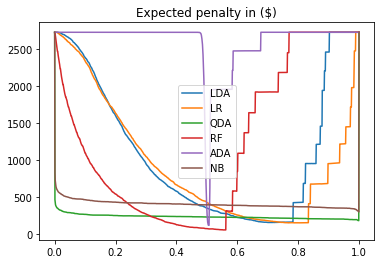

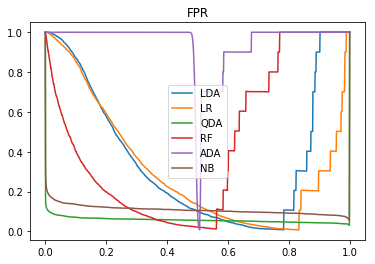

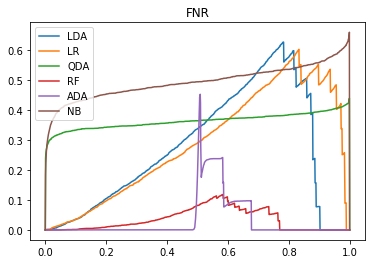

In [9]:
X = np.array(X_train)
y = np.array(y_train)
X = impute_missing_data(X)
X,y = over_sample_smote(X,y)
y = encode_decision(y)
X = standardize_data(X)
X,y = remove_outliers(X,y)
X = create_orthogonal_matrix(X)
X = select_features(X,y)

print()


fp = 5000
fn = 500
n_threshold = 1111
clfs = [clf_LDA,clf_LR,clf_QDA,clf_RF,clf_abc,clf_NB]
clf_names = ['LDA', 'LR', 'QDA', 'RF','ADA','NB']
k=10
for clf,clf_name in zip(clfs,clf_names):
    ev,fp_count,fn_count,thres,min_cost = kfold_analysis(clf,X,y,fp,fn,k,n_threshold)
    print(clf_name," --> ",'min_cost : ',min_cost,',thres : ',thres)
    plt.figure(1)
    plt.plot(np.linspace(0,1,n_threshold), ev)
    plt.title('Expected penalty in ($)')
    plt.figure(2)
    plt.plot(np.linspace(0,1,n_threshold), fp_count)
    plt.title('FPR')
    plt.figure(3)
    plt.plot(np.linspace(0,1,n_threshold), fn_count)
    plt.title('FNR')
plt.figure(1)    
plt.legend(clf_names)
plt.figure(2)    
plt.legend(clf_names)
plt.figure(3)    
plt.legend(clf_names)
plt.show()

# Performance of various Models for 2nd case ($\$5000$ : $\$5000$)

Number of records before SMOTE sampling  3703
Number of records after SMOTE sampling  6480
LabelEncoder()
Number of records before removing outliers  6480
Number of records after removing outliers  5832
Number of attributes before PCA  219
Number of attributes after PCA  60
20  attributes are selected out of  60  attributes by RF

LDA  -->  min_cost :  1036.52429568 ,thres :  0.475675675676
LR  -->  min_cost :  998.800195023 ,thres :  0.56036036036
QDA  -->  min_cost :  936.191522357 ,thres :  0.0036036036036
RF  -->  min_cost :  212.622477032 ,thres :  0.444594594595
ADA  -->  min_cost :  701.326393947 ,thres :  0.500900900901
NB  -->  min_cost :  1190.81011067 ,thres :  0.0018018018018


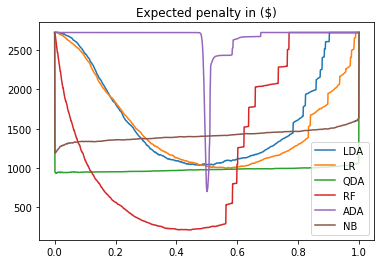

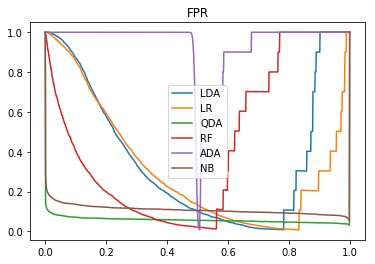

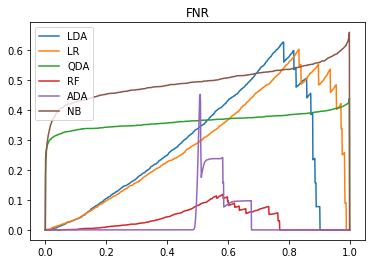

In [10]:
X = np.array(X_train)
y = np.array(y_train)
X = impute_missing_data(X)
X,y = over_sample_smote(X,y)
y = encode_decision(y)
X = standardize_data(X)
X,y = remove_outliers(X,y)
X = create_orthogonal_matrix(X)
X = select_features(X,y)

print()

fp = 5000
fn = 5000
n_threshold = 1111
clfs = [clf_LDA,clf_LR,clf_QDA,clf_RF,clf_abc,clf_NB]
clf_names = ['LDA', 'LR', 'QDA', 'RF','ADA','NB']
k=10
for clf,clf_name in zip(clfs,clf_names):
    ev,fp_count,fn_count,thres,min_cost = kfold_analysis(clf,X,y,fp,fn,k,n_threshold)
    print(clf_name," --> ",'min_cost : ',min_cost,',thres : ',thres)
    plt.figure(1)
    plt.plot(np.linspace(0,1,n_threshold), ev)
    plt.title('Expected penalty in ($)')
    plt.figure(2)
    plt.plot(np.linspace(0,1,n_threshold), fp_count)
    plt.title('FPR')
    plt.figure(3)
    plt.plot(np.linspace(0,1,n_threshold), fn_count)
    plt.title('FNR')
plt.figure(1)    
plt.legend(clf_names)
plt.figure(2)    
plt.legend(clf_names)
plt.figure(3)    
plt.legend(clf_names)
plt.show()